In [1]:
# -*- coding: utf-8 -*-

!pip install lpips scikit-image

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import os
from PIL import Image
import requests
import zipfile
import shutil
import lpips
from skimage.metrics import structural_similarity as compare_ssim

# --- SRCNN Model ---
class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()
        self.layer1 = nn.Conv2d(3, 64, kernel_size=9, padding=4)
        self.layer2 = nn.Conv2d(64, 32, kernel_size=5, padding=2)
        self.layer3 = nn.Conv2d(32, 3, kernel_size=5, padding=2)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x)
        return x

# --- Dataset Preparation ---
class DIV2KDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, transform=None, upscale_factor=4, crop_size=256):
        self.root_dir = root_dir
        self.transform = transform
        self.image_filenames = os.listdir(root_dir)
        self.upscale_factor = upscale_factor
        self.crop_size = crop_size

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.image_filenames[idx])
        img = Image.open(img_path).convert('RGB')

        img = img.resize((self.crop_size, self.crop_size), Image.BICUBIC)

        lr_img = img.resize(
            (self.crop_size // self.upscale_factor, self.crop_size // self.upscale_factor),
            Image.BICUBIC
        )
        lr_img = lr_img.resize((self.crop_size, self.crop_size), Image.BICUBIC)

        if self.transform:
            img = self.transform(img)
            lr_img = self.transform(lr_img)

        return lr_img, img

# --- Download DIV2K Train and Validation Dataset ---
os.makedirs('data', exist_ok=True)
div2k_train_url = 'http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip'
div2k_valid_url = 'http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_HR.zip'

train_zip_path = 'data/DIV2K_train_HR.zip'
valid_zip_path = 'data/DIV2K_valid_HR.zip'
train_extract_path = 'data/DIV2K_train_HR'
valid_extract_path = 'data/DIV2K_valid_HR'

if not os.path.exists(train_extract_path):
    print("Downloading DIV2K train dataset...")
    r = requests.get(div2k_train_url, stream=True)
    with open(train_zip_path, 'wb') as f:
        shutil.copyfileobj(r.raw, f)

    print("Extracting DIV2K train dataset...")
    with zipfile.ZipFile(train_zip_path, 'r') as zip_ref:
        zip_ref.extractall('data')
    os.remove(train_zip_path)

if not os.path.exists(valid_extract_path):
    print("Downloading DIV2K validation dataset...")
    r = requests.get(div2k_valid_url, stream=True)
    with open(valid_zip_path, 'wb') as f:
        shutil.copyfileobj(r.raw, f)

    print("Extracting DIV2K validation dataset...")
    with zipfile.ZipFile(valid_zip_path, 'r') as zip_ref:
        zip_ref.extractall('data')
    os.remove(valid_zip_path)

# --- Hyperparameters ---
batch_size = 16
epochs = 50
learning_rate = 1e-4
upscale_factor = 2
crop_size = 256

# --- Paths ---
train_dir = 'data/DIV2K_train_HR'
valid_dir = 'data/DIV2K_valid_HR'

# --- Transforms ---
transform = transforms.Compose([
    transforms.ToTensor()
])

# --- Dataset and DataLoader ---
train_dataset = DIV2KDataset(train_dir, transform=transform, upscale_factor=upscale_factor, crop_size=crop_size)
valid_dataset = DIV2KDataset(valid_dir, transform=transform, upscale_factor=upscale_factor, crop_size=crop_size)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False)

# --- Model, Loss, Optimizer ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SRCNN().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# --- LPIPS Model ---
lpips_model = lpips.LPIPS(net='alex').to(device)

def psnr(pred, target, max_val=1.0):
    mse = torch.mean((pred - target) ** 2)
    if mse == 0:
        return 100
    return 20 * torch.log10(max_val / torch.sqrt(mse))

def evaluate_metrics(sr_img, hr_img):
    sr_np = sr_img.squeeze().cpu().numpy().transpose(1, 2, 0)
    hr_np = hr_img.squeeze().cpu().numpy().transpose(1, 2, 0)
    ssim_score = compare_ssim(sr_np, hr_np, channel_axis=-1, data_range=1.0)
    sr_tensor = sr_img.to(device)
    hr_tensor = hr_img.to(device)
    lpips_score = lpips_model(sr_tensor, hr_tensor).item()
    return ssim_score, lpips_score

# --- Training Loop ---
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for lr_imgs, hr_imgs in train_loader:
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)

        outputs = model(lr_imgs)
        loss = criterion(outputs, hr_imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    model.eval()
    val_psnr = 0.0
    with torch.no_grad():
        for lr_imgs, hr_imgs in valid_loader:
            lr_imgs = lr_imgs.to(device)
            hr_imgs = hr_imgs.to(device)
            outputs = model(lr_imgs)
            val_psnr += psnr(outputs, hr_imgs).item()

    val_psnr /= len(valid_loader)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Val PSNR: {val_psnr:.2f} dB')

# --- Save Model ---
torch.save(model.state_dict(), 'srcnn_div2k.pth')

# --- Final Test Evaluation ---
print("\nEvaluating model on test set...")
model.eval()
test_psnr = 0.0
test_ssim = 0.0
test_lpips = 0.0

with torch.no_grad():
    for lr_imgs, hr_imgs in valid_loader:
        lr_imgs = lr_imgs.to(device)
        hr_imgs = hr_imgs.to(device)
        outputs = model(lr_imgs)

        test_psnr += psnr(outputs, hr_imgs).item()
        ssim_score, lpips_score = evaluate_metrics(outputs, hr_imgs)
        test_ssim += ssim_score
        test_lpips += lpips_score

total = len(valid_loader)
print(f'Final Test PSNR: {test_psnr / total:.2f} dB')
print(f'Final Test SSIM: {test_ssim / total:.4f}')
print(f'Final Test LPIPS: {test_lpips / total:.4f}')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 99.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 90.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 45.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalli

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 232MB/s]


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Epoch [1/50], Loss: 0.0582, Val PSNR: 18.53 dB
Epoch [2/50], Loss: 0.0104, Val PSNR: 22.04 dB
Epoch [3/50], Loss: 0.0058, Val PSNR: 23.43 dB
Epoch [4/50], Loss: 0.0045, Val PSNR: 24.44 dB
Epoch [5/50], Loss: 0.0037, Val PSNR: 25.18 dB
Epoch [6/50], Loss: 0.0033, Val PSNR: 25.57 dB
Epoch [7/50], Loss: 0.0031, Val PSNR: 25.82 dB
Epoch [8/50], Loss: 0.0029, Val PSNR: 26.00 dB
Epoch [9/50], Loss: 0.0029, Val PSNR: 26.16 dB
Epoch [10/50], Loss: 0.0028, Val PSNR: 26.24 dB
Epoch [11/50], Loss: 0.0027, Val PSNR: 26.05 dB
Epoch [12/50], Loss: 0.0027, Val PSNR: 26.50 dB
Epoch [13/50], Loss: 0.0026, Val PSNR: 26.59 dB
Epoch [14/50], Loss: 0.0025, Val PSNR: 26.67 dB
Epoch [15/50], Loss: 0.0025, Val PSNR: 26.76 dB
Epoch [16/50], Loss: 0.0024, Val PSNR: 26.83 dB
Epoch [17/50], Loss: 0.0024, Val PSNR: 26.90 dB
Epoch [18/50], Loss: 0.0024, Val PSNR: 26.94 dB
Epoch [19/50], Loss: 0.0023, Val PSNR: 27.01 dB
Epoch [20

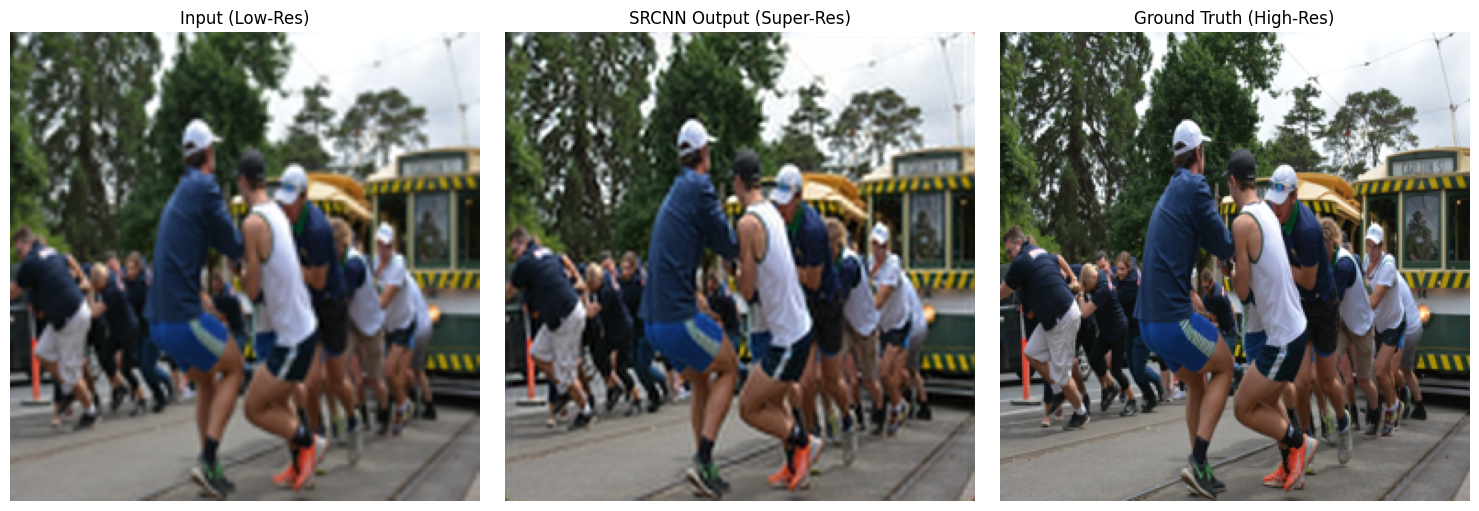

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Choose one sample from validation set
lr_img, hr_img = valid_dataset[0]
lr_img_batch = lr_img.unsqueeze(0).to(device)

# Model prediction
model.eval()
with torch.no_grad():
    sr_img = model(lr_img_batch).squeeze(0).cpu()

# Convert tensors to NumPy for display
def tensor_to_np(img_tensor):
    img_np = img_tensor.detach().numpy().transpose(1, 2, 0)
    return np.clip(img_np, 0, 1)

lr_np = tensor_to_np(lr_img)
sr_np = tensor_to_np(sr_img)
hr_np = tensor_to_np(hr_img)

# Plot
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(lr_np)
plt.title('Input (Low-Res)')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(sr_np)
plt.title('SRCNN Output (Super-Res)')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(hr_np)
plt.title('Ground Truth (High-Res)')
plt.axis('off')

plt.tight_layout()
plt.show()
